# Word2Vec - Finding similar movies in the MovieLens datset

Can we find an embedding space built on the movielens dataset to compare distance between titles?

Consider each person's viewing history as a series of titles.
Build a model to predict the next title watched based on the ones before it.
Or build a model to predict the middle title based on the ones either side.

Represent the titles as an embedding vector.
Build a dense layer on top of the embedding vector to predict the next title.

Follow an approach similar to Word2Vec.
Instead of treating each word as an entity or token, we use each title.
We treat the vocabulary as the set of titles.

1. Load the movielens dataset
2. Convert each movie title to an integer token
3. Create an embedding layer on the tokens

References:
* https://en.wikipedia.org/wiki/Word2vec

Start by importing stuff:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl

plt.style.use("seaborn-v0_8-whitegrid")

import sys
from pathlib import Path

sys.path.append(str(Path().absolute().parent))

import utilities

## Load data

Load the movielens dataset.

In [2]:
ratings_df = utilities.load_ratings()
ratings_df

userId,movieId,rating,timestamp
i64,i64,f64,i64
1,5952,4.0,1147868053
1,2012,2.5,1147868068
1,2011,2.5,1147868079
1,1653,4.0,1147868097
1,1250,4.0,1147868414
…,…,…,…
162541,1259,4.5,1240953609
162541,1266,5.0,1240953613
162541,1556,1.0,1240953650


Each person has rated at least 20 titles.

In [3]:
ratings_df.group_by("userId").count().sort("count", descending=True)

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_44973/2997066704.py:1: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  ratings_df.group_by("userId").count().sort("count", descending=True)


userId,count
i64,u32
72315,32202
80974,9178
137293,8913
33844,7919
20055,7488
…,…
162277,20
162304,20
162351,20


Not all movieIds are sequential, we have 59k IDs with values up to 209k. We will need to tokenize them before training.

In [4]:
print(ratings_df["movieId"].max())
ratings_df.group_by("movieId").count().sort("count", descending=True)

209171


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_44973/3773860017.py:2: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  ratings_df.group_by("movieId").count().sort("count", descending=True)


movieId,count
i64,u32
356,81491
318,81482
296,79672
593,74127
2571,72674
…,…
203286,1
183621,1
134186,1


We will make a small subset of data for initial building and testing our models

We limit to the top 50 movies and users with at least 20 ratings.

In [5]:
top_movie_ids = utilities.get_most_frequent_movies(ratings_df)
ratings_df = ratings_df.join(top_movie_ids, on="movieId", how="inner")


user_id_counts = (
    ratings_df.group_by("userId").len().filter(pl.col("len") >= 20)[["userId"]]
)
ratings_df = ratings_df.join(user_id_counts, on="userId", how="inner")
ratings_df.shape

(1511948, 4)

## Build model architecture

We will build the embedding using word2vec. There are two forms:

1. Continuous Bag of Words (CBOW):
In CBOW, the model predicts the current word (target word) based on the context words within a fixed window size.

1. Skip-gram:
In Skip-gram, the model predicts context words (surrounding words) given the current word (target word).

CBOW is generally faster to train compared to Skip-gram, especially when using small training datasets.
In our case the words are actually movies.

We will use CBOW for this test as hopefully its faster and more appropriate on a smallish training dataset.
Therefore we need to define a window of entities to train over. We will start with 3, so predict the current entity given the one before and the one after.


### Data preparation

We need to get sequenences of tokens. So we next create tokens from the movieIds as they do not start from 0 and are not sequential.

In [6]:
ratings_df, user_id_mapping, movie_id_mapping = utilities.map_users_and_movies(
    ratings_df
)
ratings_df = ratings_df.rename({"movieIdMapped": "token"})
display(ratings_df.head(4))

userId,movieId,rating,timestamp,userIdMapped,token
i64,i64,f64,i64,u32,u32
2,5952,5.0,1141415528,0,46
2,150,4.0,1141415790,0,5
2,3578,5.0,1141415803,0,42
2,380,1.0,1141415808,0,13


Then for each userId we convert the tokens in to a list.

In [7]:
import tqdm


def get_sequences_from_df(ratings_df: pl.DataFrame):
    sequences = []
    for _user_id in tqdm.tqdm(ratings_df["userId"].unique()):
        sequences.append(
            ratings_df.filter(pl.col("userId") == _user_id)["token"].to_list()
        )
    return sequences

In [8]:
sequences = get_sequences_from_df(ratings_df)
print(sequences[0][:10])

100%|██████████| 49276/49276 [00:03<00:00, 14016.76it/s]

[46, 5, 42, 13, 16, 0, 39, 37, 27, 4]


Split sequences randomly to train/test sets

In [9]:
import random


def split_train_test(data, test_ratio=0.2):
    data_copy = data.copy()
    random.shuffle(data_copy)

    split_index = int(len(data_copy) * (1 - test_ratio))
    train_set = data_copy[:split_index]
    test_set = data_copy[split_index:]

    return train_set, test_set


# Example usage:
data = [
    ["sample1", "feature1", "feature2"],
    ["sample2", "feature1", "feature2"],
    ["sample3", "feature1", "feature2"],
    ["sample4", "feature1", "feature2"],
    ["sample5", "feature1", "feature2"],
]

sequences_train, sequences_test = split_train_test(sequences, test_ratio=0.2)
len(sequences_train), len(sequences_test)

(39420, 9856)

We can now create the CBOW dataset from the sequences.
We will use a small embedding size and a window of only 1.

So in a sequence of (w1, w2, w3) we get training tuples as: predict w2 given [w1, w3].

We create a `collate_fn` to collect all the sequences and combine into tensors for training.

```
Sequence Data (e.g., Text, Time Series):
For sequence data, such as text or time series, the shape of a batch is often: (batch_size, sequence_length, input_dim).
batch_size is the number of sequences in the batch.
sequence_length is the length of each sequence.
input_dim represents the dimensionality of each element in the sequence (e.g., word embeddings for text).
```

In [10]:
from torch.utils.data import Dataset, DataLoader
import torch


class CBOWDataset(Dataset):
    def __init__(self, sequences: list[int], window_size: int):
        self.sequences = sequences
        self.window_size = window_size

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        data = []
        for i in range(len(sequence)):
            target_word = sequence[i]
            context = []
            for j in range(
                max(0, i - self.window_size),
                min(len(sequence), i + self.window_size + 1),
            ):
                if j != i:
                    context.append(sequence[j])
            data.append((context, target_word))
        return data


def collate_fn(batch):
    # join all training examples into single tensor
    data = []
    targets = []
    for batch_item in batch:
        for _item in batch_item[1:-1]:
            data.append(_item[0])
            targets.append(_item[1])

    return torch.tensor(data), torch.tensor(targets).view(-1, 1)

In [11]:
vocab_size = ratings_df["movieId"].unique().count()
window_size = 1

# Create dataset and dataloader
dataset_train = CBOWDataset(sequences_train, window_size)
dataloader_train = DataLoader(
    dataset_train, batch_size=64, shuffle=False, collate_fn=collate_fn
)
dataset_test = CBOWDataset(sequences_test, window_size)
dataloader_test = DataLoader(
    dataset_test, batch_size=64, shuffle=False, collate_fn=collate_fn
)

The training data is made up of pairs of tokens and the token from the middle. Here is a preview:

In [12]:
dataset_train.__getitem__(0)[:5]

[([26], 8), ([8, 28], 26), ([26, 16], 28), ([28, 6], 16), ([16, 10], 6)]

Following the dataloader we get.

In [13]:
batch = next(iter(dataloader_train))
batch

(tensor([[ 8, 28],
         [26, 16],
         [28,  6],
         ...,
         [ 5, 47],
         [11, 46],
         [47, 45]]),
 tensor([[26],
         [28],
         [16],
         ...,
         [11],
         [47],
         [46]]))

### Model architecture

The input to the model is a one-hot encoded vector representing the context words.
The hidden layer is a projection layer (embedding layer) that converts the one-hot encoded vectors into dense embedding vectors.
The output layer predicts the probability distribution of the target word given the context.
The model is trained to minimize the difference between the predicted probabilities and the actual word (softmax output).


The input to the model is a series of tokens representing the movies.
(These are converted to one-hot encoded vectors. Not needed?)
The tokens are converted into embedding vectors.

The embedding vectors of the context words are averaged to obtain a single context vector.
This context vector represents the overall context of the surrounding words.
The context vector is then passed through a linear transformation followed by a softmax activation function to produce a probability distribution over the entire vocabulary.

We then use a dense layer(s) to find the probability of each element in the vocabulary.
We compare against the true target word and use cross entropy loss to train the model weights, including the embedding layer.


With large vocabularies cross entropy loss can be expensive. There are approximations which are faster. We will stick with the full computation as we have a small vocab.

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pytl


class CBOWModel(pytl.LightningModule):
    def __init__(
        self, vocab_size: int, embedding_dim: int, learning_rate: float = 1e-2
    ):
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

        self.learning_rate = learning_rate
        self.train_log_error = []
        self.val_log_error = []

    def forward(self, context):
        embedded_context = self.embeddings(context)
        # sum over context to get single embedding vector
        sum_embedded_context = torch.sum(embedded_context, dim=1)
        output = self.linear(sum_embedded_context)
        return output

    def training_step(self, batch, batch_idx):
        context, target = batch
        context = context.squeeze(1)
        target = target.squeeze(1)
        output = self(context)
        loss = nn.CrossEntropyLoss()(output, target)

        self.train_log_error.append(loss.item())
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        context, target = batch
        context = context.squeeze(1)
        target = target.squeeze(1)
        output = self(context)
        loss = nn.CrossEntropyLoss()(output, target)

        self.val_log_error.append(loss.item())
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

Test with a single training example

We have at least 64*20 sequences in the training example and they return a value for each title in the vocabulary (50).

In [15]:
embedding_dim = 5
model = CBOWModel(vocab_size, embedding_dim)
batch = next(iter(dataloader_train))
model(batch[0]).shape

torch.Size([1838, 50])

Custom logger to store metrics in python dictionaries

In [16]:
from pytorch_lightning.loggers import Logger
from pytorch_lightning.utilities import rank_zero_only


class DictLogger(Logger):
    def __init__(self):
        super().__init__()
        self.metrics = {}

    @property
    def name(self):
        return "DictLogger"

    @property
    def version(self):
        return "1.0"

    @rank_zero_only
    def log_hyperparams(self, params):
        pass

    @rank_zero_only
    def log_metrics(self, metrics, step):
        for k, v in metrics.items():
            if k not in self.metrics:
                self.metrics[k] = []
            self.metrics[k].append((step, v))

    def save(self):
        pass

    @rank_zero_only
    def finalize(self, status):
        pass

Add early stopping and enforce a minimum of 6 epochs (it takes a few epochs to start improving over a mean baseline)

In [17]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import Callback


class EarlyStoppingWithMinEpochs(Callback):
    def __init__(self, min_epochs, **kwargs):
        super().__init__()
        self.min_epochs = min_epochs
        self.early_stopping = EarlyStopping(**kwargs)

    def on_validation_end(self, trainer, pl_module):
        if trainer.current_epoch >= self.min_epochs - 1:
            self.early_stopping.on_validation_end(trainer, pl_module)

    def on_train_end(self, trainer, pl_module):
        self.early_stopping.on_train_end(trainer, pl_module)


early_stop_callback = EarlyStoppingWithMinEpochs(
    min_epochs=6, monitor="val_loss", patience=3, mode="min"
)

Train the model

In [18]:
embedding_dim = 20
model = CBOWModel(vocab_size, embedding_dim)
logger = DictLogger()
trainer = pytl.Trainer(
    max_epochs=20,
    logger=logger,
    log_every_n_steps=1,
    callbacks=[early_stop_callback],
)
trainer.fit(model, train_dataloaders=dataloader_train, val_dataloaders=dataloader_test)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/stantoon/Documents/VariousProjects/github/data-analysis/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/stantoon/Documents/VariousProjects/github/data-analysis/neural_networks/movie_lens/embeddings/DictLogger/1.0/checkpoints exists and is not empty.

  | Name       | Type      | Params | Mode 
-------------------------------------------------
0 | embeddings | Embedding | 1.0 K  | train
1 | linear     | Linear    | 1.1 K  | train
-------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/stantoon/Documents/VariousProjects/github/data-analysis/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/stantoon/Documents/VariousProjects/github/data-analysis/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 11: 100%|██████████| 616/616 [00:08<00:00, 71.62it/s, v_num=1.0, train_loss_step=3.630, val_loss_step=3.620, val_loss_epoch=3.550, train_loss_epoch=3.550]


Plotting train/val epoch loss

Looks like we are learning reasonably well.

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_44973/3638243156.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


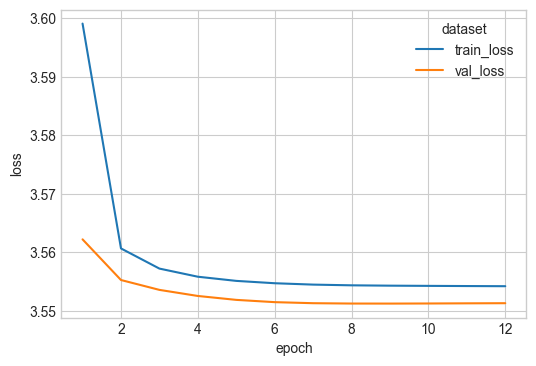

In [19]:
def training_logs_to_df(logger, name: str = None):
    df = (
        pl.concat(
            [
                pl.DataFrame(
                    logger.metrics["train_loss_epoch"],
                    orient="row",
                    schema=["batch", "train_loss"],
                ),
                pl.DataFrame(
                    logger.metrics["val_loss_epoch"],
                    orient="row",
                    schema=["batch", "val_loss"],
                ).drop("batch"),
            ],
            how="horizontal",
        )
        .with_row_index(name="epoch", offset=1)
        .unpivot(index=["epoch", "batch"], variable_name="dataset", value_name="loss")
    )
    if name:
        df = df.with_columns(pl.lit(name).alias("name"))
    return df


plot_df = training_logs_to_df(logger, name="nn_inner")


fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=plot_df, x="epoch", y="loss", hue="dataset", ax=ax)
fig.show()

### Baseline model

A baseline model can be a uniform distribution over the vocab.
We use this to ensure our model is learning something meaningful.

Loss for the model

In [20]:
y_est, y_true = [], []
for idx, batch in enumerate(dataloader_train):
    _x, _y = batch
    _y_est = model(_x)
    y_est.append(_y_est.detach().numpy())
    y_true.append(_y.detach().numpy())

y_est = np.concatenate(y_est)
y_true = np.concatenate(y_true)

nn.CrossEntropyLoss()(torch.tensor(y_est), torch.tensor(y_true).squeeze(1))

tensor(3.5518)

Loss for a uniform distribution

CrossEntropyLoss applies a softmax first, so the fill value doesn't matter here.

In [21]:
y_est_uniform = np.full(shape=y_est.shape, fill_value=1.0)
nn.CrossEntropyLoss()(torch.tensor(y_est_uniform), torch.tensor(y_true).squeeze(1))

tensor(3.9120, dtype=torch.float64)

### Get embeddings

Get movie embeddings from the model layers and store for later use.

In [22]:
from pathlib import Path

movie_embeddings_df = ratings_df["movieId", "token"].unique().sort("movieId")
movie_embeddings_df = pl.concat(
    [movie_embeddings_df, pl.DataFrame(model.embeddings.weight.detach().numpy())],
    how="horizontal",
).drop("token")
display(movie_embeddings_df)

Path("../data/embeddings").mkdir(parents=True, exist_ok=True)
movie_embeddings_df.write_parquet("../data/embeddings/word2vec_20.parquet")

movieId,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19
i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1,0.170268,0.005285,0.173711,-0.514811,-0.717947,-0.426253,0.095356,0.199622,0.449421,0.635752,0.000855,-0.27404,-0.381104,0.076468,0.117747,0.058355,-0.195489,-0.429596,0.263023,0.047042
32,-0.508879,-0.034648,-0.601913,-0.150512,-0.586849,-0.113532,-0.202662,0.321145,0.165959,0.050083,-0.078404,0.570016,-0.045625,-0.14668,0.304445,-0.128906,-0.543937,-0.180518,-0.055841,0.024215
47,-0.031499,0.355408,-0.286842,-0.124137,0.329915,0.005808,0.354786,0.341577,0.198219,0.110213,0.412576,-0.344803,-0.210823,-0.445296,0.594245,-0.515395,0.356284,0.213535,-0.142556,0.032458
50,-0.324363,0.060988,0.007004,-0.091061,0.266039,-0.519057,0.006314,-0.527639,-0.69752,0.073614,0.83331,0.505465,-0.053987,-0.890503,0.081994,-0.145882,-0.237505,0.496448,-0.316936,0.07419
110,0.246857,-0.459349,0.304814,0.228468,0.538425,-0.34115,-0.468971,0.226764,-0.623984,0.341686,-0.251205,0.095348,0.19869,0.210442,-0.183482,-0.010722,-0.408665,-0.622425,0.272464,-0.16026
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
4993,-0.006215,0.108027,-0.323896,-0.340742,-0.128894,-0.168293,-0.813256,-0.417005,0.524438,0.162587,-0.490397,-0.189253,-0.293136,-0.726565,-1.080682,0.441643,0.52161,-0.08282,0.690598,-0.103665
5952,-0.558613,-0.147518,0.790067,-0.84381,-0.155056,0.188955,0.141412,0.286123,-0.389624,-0.765076,-0.872002,0.416089,-0.080197,0.419377,-0.193393,0.610264,0.568712,0.614561,-0.481618,-0.443433
7153,0.006625,0.832853,-0.093344,0.031611,-0.413336,-0.008178,-0.171429,0.01716,-0.150033,-0.930672,0.746316,-0.609427,0.974754,0.796484,-0.476131,0.371503,-0.033553,0.367805,0.717005,-0.464248


# Appendix

## TODO
* Larger dataset
* Using

### Ratings based
The above Word2Vec approach will be assuming that people watched films that are similar in succession.

We have explicit ratings in the dataset we can use for a better indication.
We are assuming that people rate highly movies that are similar.

We also have genre information, how can we exploit this?

### Text dataset
Can we confirm the above approach with text data.

### Predict sequences

Given a starting movie, predict the sequences of movies the user will rate next.

In [23]:
movies_df = utilities.load_movies()
movies_df = movies_df.join(movie_id_mapping, on="movieId", how="inner")
movies_df

movieId,title,genres,movieIdMapped
i64,str,str,u32
1,"""Toy Story (1995)""","""Adventure|Animation|Children|C…",0
32,"""Twelve Monkeys (a.k.a. 12 Monk…","""Mystery|Sci-Fi|Thriller""",1
47,"""Seven (a.k.a. Se7en) (1995)""","""Mystery|Thriller""",2
50,"""Usual Suspects, The (1995)""","""Crime|Mystery|Thriller""",3
110,"""Braveheart (1995)""","""Action|Drama|War""",4
…,…,…,…
4993,"""Lord of the Rings: The Fellows…","""Adventure|Fantasy""",45
5952,"""Lord of the Rings: The Two Tow…","""Adventure|Fantasy""",46
7153,"""Lord of the Rings: The Return …","""Action|Adventure|Drama|Fantasy""",47


We make sequence of 'Lord of the Rings: The Fellows...' and 'Lord of the Rings: The Return ...'.
The model predicts the most likely middle movie as 'Lord of the Rings: The Two Tow...'

In [24]:
y_est = model(torch.tensor([[45, 47]]))
movies_df.filter(pl.col("movieIdMapped") == y_est.argmax())

movieId,title,genres,movieIdMapped
i64,str,str,u32
5952,"""Lord of the Rings: The Two Tow…","""Adventure|Fantasy""",46


## Larger dataset

In [25]:
top_movie_ids = (
    ratings_df.group_by("movieId")
    .count()
    .sort("count", descending=True)
    .head(200)[["movieId"]]
)
ratings_med_df = ratings_df.join(top_movie_ids, on="movieId", how="inner")

user_id_counts = (
    ratings_med_df.group_by("userId").count().filter(pl.col("count") >= 20)[["userId"]]
)
ratings_med_df = ratings_med_df.join(user_id_counts, on="userId", how="inner")
ratings_med_df.shape

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_44973/2374773301.py:3: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_44973/2374773301.py:10: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  ratings_med_df.group_by("userId").count().filter(pl.col("count") >= 20)[["userId"]]


(1511948, 6)

In [26]:
ratings_med_df, token_mapping = convert_movies_to_tokens(ratings_med_df)
display(ratings_med_df.head(4))

sequences = get_sequences_from_df(ratings_med_df)
print(sequences[0][:10])

vocab_size = ratings_med_df["movieId"].unique().count()
window_size = 1

# Create dataset and dataloader
dataset = CBOWDataset(sequences, window_size)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

embedding_dim = 20
model = CBOWModel(vocab_size, embedding_dim)
trainer = pytl.Trainer(max_epochs=1)
trainer.fit(model, dataloader)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(moving_average(model.train_log_error, 100), label="train")
ax.set_title(f"Training error")
ax.set_xlabel("Batches")
ax.set_ylabel("LL")
ax.legend()
fig.show()

embedding_matrix = model.embeddings.weight
similarities = calculate_cosine_similarity(embedding_matrix.cpu()).detach().numpy()
similarities[np.triu_indices(similarities.shape[0], k=1)] = np.nan

labels = token_mapping.join(names_df, on="movieId").sort("token")["title"].to_list()

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    data=similarities,
    ax=ax,
    xticklabels=labels,
    yticklabels=labels,
)
fig.show()

NameError: name 'convert_movies_to_tokens' is not defined

Strong correlations

In [ ]:
indices = top_n_indices(similarities)
print(similarities[indices[0][0], indices[0][1]])
print(labels[indices[0][0]], labels[indices[0][1]])
print(similarities[indices[1][0], indices[1][1]])
print(labels[indices[1][0]], labels[indices[1][1]])
print(similarities[indices[2][0], indices[2][1]])
print(labels[indices[2][0]], labels[indices[1][1]])
indices

0.9033904
American Pie (1999) Austin Powers: International Man of Mystery (1997)
0.8816099
One Flew Over the Cuckoo's Nest (1975) Casablanca (1942)
0.8643362
Donnie Darko (2001) Casablanca (1942)


[(134, 103),
 (78, 68),
 (156, 151),
 (107, 104),
 (141, 96),
 (198, 188),
 (119, 100),
 (156, 149),
 (109, 74),
 (196, 193)]

In [ ]:
raise NotImplementedError

NotImplementedError: 